In [1]:
pip install tensorflow


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define paths to your datasets
train_dir = '/content/drive/MyDrive/dataset_path/dataset_path/train'
val_dir = '/content/drive/MyDrive/dataset_path/dataset_path/val'
test_dir = '/content/drive/MyDrive/dataset_path/dataset_path/test'

# Image data generators with extensive augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical',
    shuffle=False
)

# Calculate class weights
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Load the ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(54, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=100,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    class_weight=class_weights
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {accuracy:.2f}')


Found 322 images belonging to 54 classes.
Found 55 images belonging to 54 classes.
Found 54 images belonging to 54 classes.


Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 4.3572 - accuracy: 0.0189

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 35s 101ms/step - loss: 4.3572 - accuracy: 0.0189 - val_loss: 4.7863 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 7s 103ms/step - loss: 3.9594 - accuracy: 0.0410 - val_loss: 3.9881 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - 6s 92ms/step - loss: 3.9511 - accuracy: 0.0379 - val_loss: 151.2149 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - 5s 79ms/step - loss: 3.8548 - accuracy: 0.0631 - val_loss: 3.9906 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 5/100
64/64 [==============================] - 5s 78ms/step - loss: 3.6625 - accuracy: 0.0726 - val_loss: 4.6694 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 6/100
64/64 [==============================] - 5s 77ms/step - loss: 3.4907 - accuracy: 0.0694 - val_loss: 4.4762 - val_accuracy: 0.0182 - lr: 2.0000e-04
Epoch 7/100
64/64 [==============================] - 6s 97ms/step - loss:

11/11 [==============================] - 0s 24ms/step


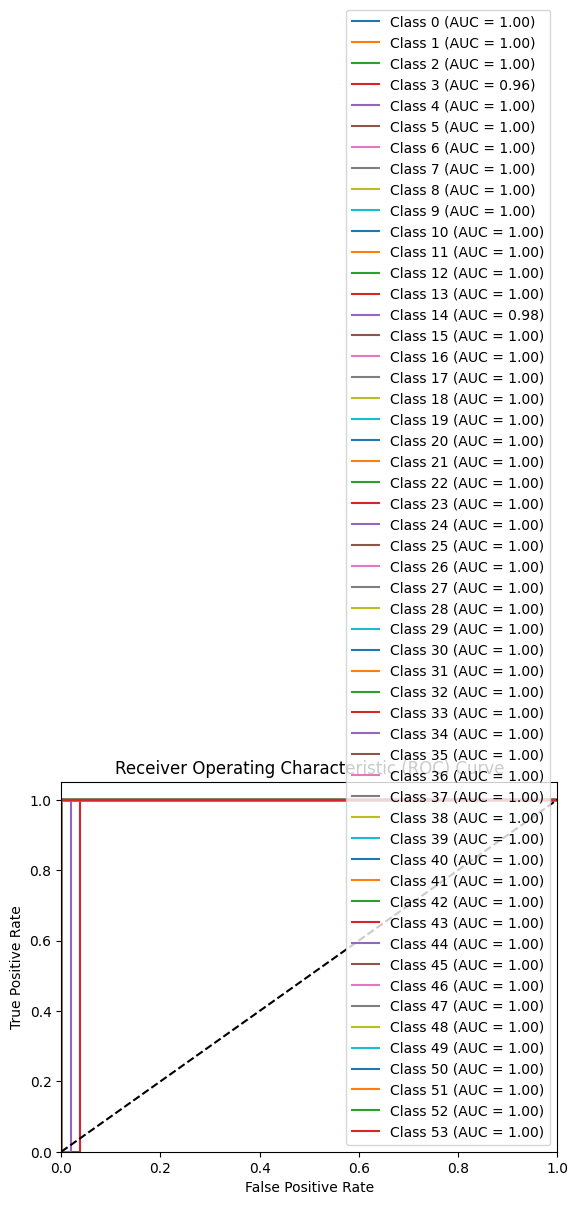

In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Generate predictions
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
y_true = test_generator.classes

# Generate predictions for all samples
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure that y_true and y_pred_classes have the same length
assert len(y_true) == len(y_pred_classes), f"Mismatch: len(y_true) = {len(y_true)}, len(y_pred_classes) = {len(y_pred_classes)}"

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [5]:
pip install matplotlib scikit-learn


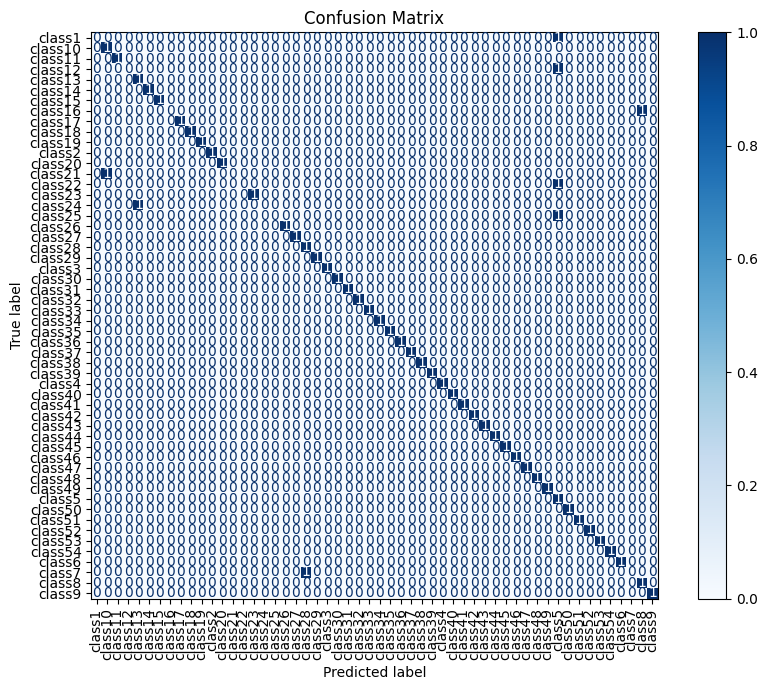

In [15]:
plt.figure(figsize=(9, 7))  # Increase the figure size for the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

11/11 [==============================] - 0s 23ms/step


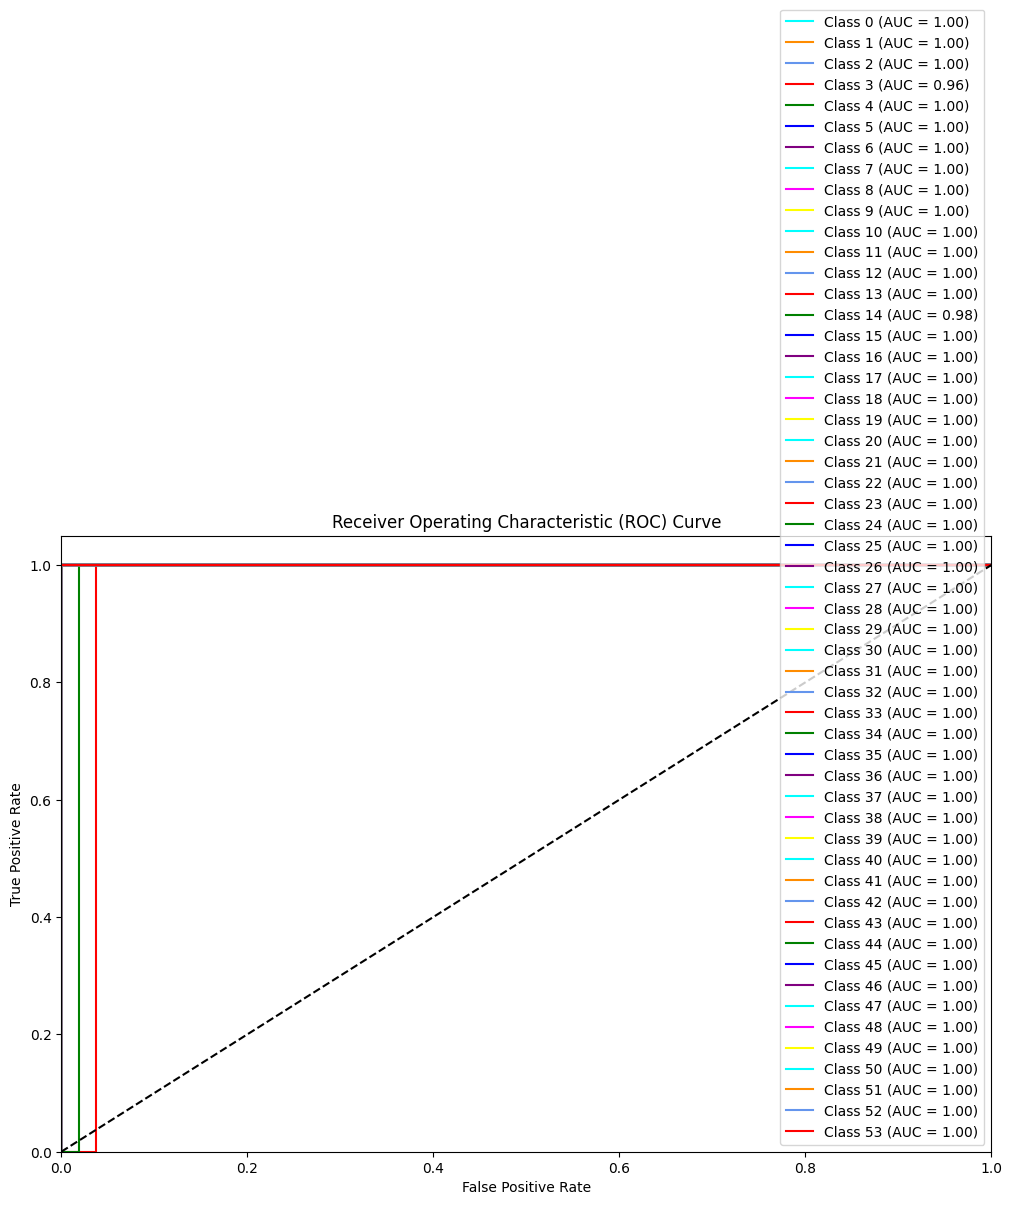

In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle


# Generate predictions
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
y_true = test_generator.classes

# Generate predictions for all samples
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure that y_true and y_pred_classes have the same length
assert len(y_true) == len(y_pred_classes), f"Mismatch: len(y_true) = {len(y_true)}, len(y_pred_classes) = {len(y_pred_classes)}"

# Binarize the output labels for ROC curve computation
y_true_binarized = label_binarize(y_true, classes=list(range(54)))

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'yellow'])
for i, color in zip(range(train_generator.num_classes), colors):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


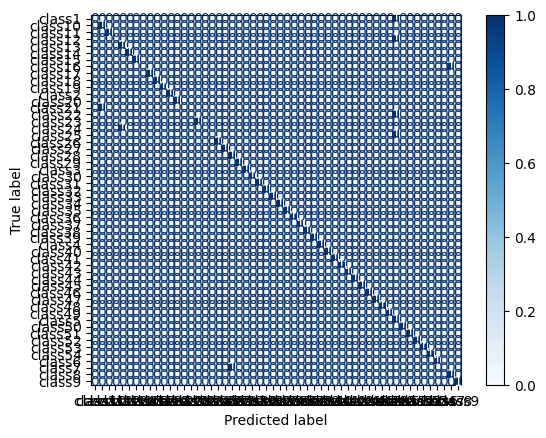

In [14]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()